# Table of Contents

* [Import and downsampling data](#Import-and-downsampling-data)
* [Modeling](#Modeling)
    * [1. Random Forest](#1.-Random-Forest)
    * [2. XGboost](#2.-XGboost )
    * [3. LightGBM](#3.-LightGBM)
    * [4. Logistic Regression with regularizations](#4.-Logistic-Regression-with-regularizations)
    * [5. KNN](#5.-KNN)      
    * [6. SVM](#6.-SVM)
* [Conclusion](#Conclusion)

## Import and downsampling data

In [1]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
import warnings
warnings.filterwarnings("ignore")

In [2]:
#import sys
#!conda install --yes --prefix {sys.prefix} -c conda-forge lightgbm
#!pip install xgboost
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
%matplotlib inline  
import statistics
from scipy import stats
from scipy.stats import t
from scipy.stats import norm
import seaborn as sns
import sklearn
import sqlite3
from sqlite3 import Error
import csv
import lightgbm

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import LinearSVC
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
#from sklearn.metrics import plot_precision_recall_curve

Use the code below to create a balanced training dataset to be used by all ML models that we build shortly. Test sets are still imbalanced.

In [3]:
from sklearn.model_selection import train_test_split

data_all = pd.read_csv('sm_data.csv')
X = data_all.iloc[:,1:]
y = data_all['TARGET']

# train test split using test_size = 0.2 
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=123)

X_train_0 = X_train.loc[y_train == 0,:].copy().sample(frac = 0.09)
X_train_1 = X_train.loc[y_train == 1,:].copy()

X_train_0['target'] = 0
X_train_1['target'] = 1

# use frac = 1 to randomize the rows
X_train_new = X_train_0.append(X_train_1).sample(frac = 1)

X_train_new_x = X_train_new.drop(columns='target')
y_train_new = X_train_new['target']

## Modeling

The first 3 models we build are tree based. Since tree based models are robust regardless of the skewed distributions of the features, we do not need to scale the features. Later on when we train other classification models that are more sensitive to the scale of features, such as logistic regression, KNN and SVM, we first transform some of the features before fitting the models.

## 1. Random Forest

In [4]:
import time
start = time.clock()

Kfold, niter, verbose, random_state = [5, 5, 0, 123] 
param_space = {'n_estimators': range(100,500,100), 'max_depth': range(1,20)}

clf = RandomForestClassifier(random_state=random_state)
cv_clf = RandomizedSearchCV(clf, param_space, cv=Kfold, n_iter=niter, verbose=verbose, n_jobs=-1) 
cv_clf.fit(X_train_new_x, y_train_new)

best_n = cv_clf.best_params_['n_estimators']
best_d = cv_clf.best_params_['max_depth']
print("Best number of trees and depth are: ", best_n, best_d)

print('completed in {} s'.format(time.clock() - start))

# write out results
rlt_dict = {}
rlt_dict['best_n'] = [best_n]
rlt_dict['best_d'] = [best_d]

rlt_df = pd.DataFrame.from_dict(rlt_dict)
rlt_df.to_csv('randomforest_cv_rlt.csv')

Best number of trees and depth are:  300 18
completed in 58.68000000000001 s


In [5]:
preds = cv_clf.predict(X_test)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, preds, labels=None, sample_weight=None)
report = classification_report(y_test, preds)
probs = cv_clf.predict_proba(X_test)
auc = roc_auc_score(y_test, probs[:,1])
accuracy = float(np.sum(preds==y_test))/y_test.shape[0] 

print("Confusion Matrix is: \n", confusion_matrix)
print("Classification Report: \n", report)
print("accuracy: %f" % (accuracy))
print("AUC: ", auc)

Confusion Matrix is: 
 [[40022 16511]
 [ 1612  3356]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.71      0.82     56533
           1       0.17      0.68      0.27      4968

   micro avg       0.71      0.71      0.71     61501
   macro avg       0.57      0.69      0.54     61501
weighted avg       0.90      0.71      0.77     61501

accuracy: 0.705322
AUC:  0.7548815167678986


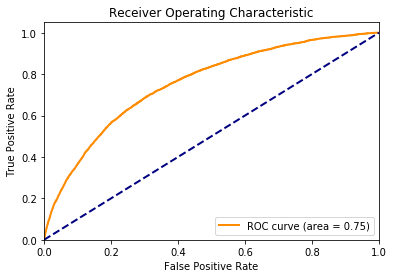

In [6]:
# plot ROC curve
y_score = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 2. XGboost 

In [7]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
import warnings
warnings.filterwarnings("ignore")

In [8]:
import time
start = time.clock()

Kfold, niter, verbose, random_state = [5, 5, 0, 123] 
param_space = {'n_estimators': range(100,500,100), 'learning_rate': [0.01,0.1,0.5], 
               'max_depth': range(1,20), 'gamma': [0.001,0.01,1,10]}
               
clf = XGBClassifier(objective='binary:logistic', verbosity=verbose, booster='gbtree', tree_method='auto', 
                            subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, 
                            reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=random_state)
cv_clf = RandomizedSearchCV(clf, param_space, cv=Kfold, n_iter=niter, verbose=verbose, n_jobs=-1)
cv_clf.fit(X_train_new_x, y_train_new)

best_n = cv_clf.best_params_['n_estimators']
best_lr = cv_clf.best_params_['learning_rate']
best_d = cv_clf.best_params_['max_depth']
best_gamma = cv_clf.best_params_['gamma']
print("Best number of trees, learning rate, depth and gamma are: ", best_n, best_lr, best_d, best_gamma)

print('completed in {} s'.format(time.clock() - start))

# write out results
rlt_dict = {}
rlt_dict['best_n'] = [best_n]
rlt_dict['best_lr'] = [best_lr]
rlt_dict['best_d'] = [best_d]
rlt_dict['best_gamma'] = [best_gamma]

rlt_df = pd.DataFrame.from_dict(rlt_dict)
rlt_df.to_csv('xgboost_cv_rlt.csv')

Best number of trees, learning rate, depth and gamma are:  300 0.1 3 0.01
completed in 96.67 s


In [9]:
preds = cv_clf.predict(X_test)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, preds, labels=None, sample_weight=None)
report = classification_report(y_test, preds)
probs = cv_clf.predict_proba(X_test)
auc = roc_auc_score(y_test, probs[:,1])
accuracy = float(np.sum(preds==y_test))/y_test.shape[0] 

print("Confusion Matrix is: \n", confusion_matrix)
print("Classification Report: \n", report)
print("accuracy: %f" % (accuracy))
print("AUC: ", auc)

Confusion Matrix is: 
 [[40378 16155]
 [ 1524  3444]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.71      0.82     56533
           1       0.18      0.69      0.28      4968

   micro avg       0.71      0.71      0.71     61501
   macro avg       0.57      0.70      0.55     61501
weighted avg       0.90      0.71      0.78     61501

accuracy: 0.712541
AUC:  0.7747674800858052


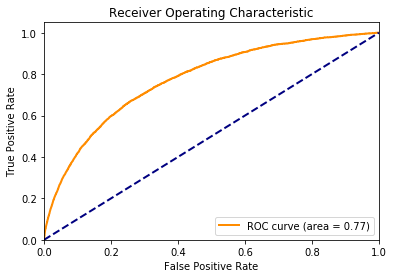

In [10]:
# plot ROC curve
y_score = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 3. LightGBM

In [4]:
import time
start = time.clock()

Kfold, niter, verbose, random_state = [5, 5, 0, 123] 
param_space = {'n_estimators': range(100,500,100), 'learning_rate': [0.01,0.1,0.5], 
               'max_depth': range(1,20)}

clf = LGBMClassifier(colsample_bytree=1, subsample=1, reg_alpha=0, reg_lambda=1, verbose=verbose)
cv_clf = RandomizedSearchCV(clf, param_space, cv=Kfold, n_iter=niter, verbose=verbose, n_jobs = -1)  
cv_clf.fit(X_train_new_x, y_train_new)
        
best_n = cv_clf.best_params_['n_estimators']
best_lr = cv_clf.best_params_['learning_rate'] 
best_d = cv_clf.best_params_['max_depth']
print("Best number of trees, learning rate, depth are: ", best_n, best_lr, best_d)

print('completed in {} s'.format(time.clock() - start))

# write out results
rlt_dict = {}
rlt_dict['best_n'] = [best_n]
rlt_dict['best_lr'] = [best_lr]
rlt_dict['best_d'] = [best_d]

rlt_df = pd.DataFrame.from_dict(rlt_dict)
rlt_df.to_csv('lightgbm_cv_rlt.csv')

Best number of trees, learning rate, depth are:  200 0.1 19
completed in 20.459999999999997 s


In [5]:
preds = cv_clf.predict(X_test)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, preds, labels=None, sample_weight=None)
report = classification_report(y_test, preds)
probs = cv_clf.predict_proba(X_test)
auc = roc_auc_score(y_test, probs[:,1])
accuracy = float(np.sum(preds==y_test))/y_test.shape[0] 

print("Confusion Matrix is: \n", confusion_matrix)
print("Classification Report: \n", report)
print("accuracy: %f" % (accuracy))
print("AUC: ", auc)

Confusion Matrix is: 
 [[40114 16419]
 [ 1515  3453]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.71      0.82     56533
           1       0.17      0.70      0.28      4968

   micro avg       0.71      0.71      0.71     61501
   macro avg       0.57      0.70      0.55     61501
weighted avg       0.90      0.71      0.77     61501

accuracy: 0.708395
AUC:  0.7740336412463465


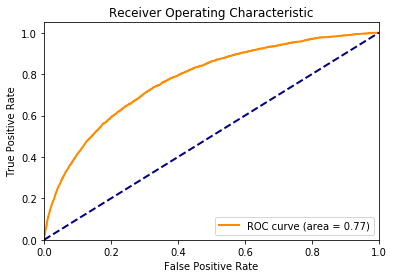

In [6]:
# plot ROC curve
y_score = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 4. Logistic Regression with regularizations

In [7]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
import warnings
warnings.filterwarnings("ignore")

In [8]:
import time
start = time.clock()

Kfold, niter, verbose, random_state = [5, 5, 0, 123] 
param_space = {'penalty': ['l1','l2'], 'C': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1, 10, 100]}
        
clf = LogisticRegression(random_state=random_state)
cv_clf = RandomizedSearchCV(clf, param_space, cv=Kfold, n_iter=niter, verbose=verbose, n_jobs = -1) 
cv_clf.fit(X_train_new_x, y_train_new)
        
best_c = cv_clf.best_params_['C']
best_penalty = cv_clf.best_params_['penalty']
print("Best C and penalty are: ", best_c, best_penalty)

print('completed in {} s'.format(time.clock() - start))

# write out results
rlt_dict = {}
rlt_dict['best_c'] = [best_c]
rlt_dict['best_penalty'] = [best_penalty]

rlt_df = pd.DataFrame.from_dict(rlt_dict)
rlt_df.to_csv('logistic_cv_rlt.csv')

Best C and penalty are:  10 l1
completed in 418.29 s


In [9]:
preds = cv_clf.predict(X_test)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, preds, labels=None, sample_weight=None)
report = classification_report(y_test, preds)
probs = cv_clf.predict_proba(X_test)
auc = roc_auc_score(y_test, probs[:,1])
accuracy = float(np.sum(preds==y_test))/y_test.shape[0] 

print("Confusion Matrix is: \n", confusion_matrix)
print("Classification Report: \n", report)
print("accuracy: %f" % (accuracy))
print("AUC: ", auc)

Confusion Matrix is: 
 [[39675 16858]
 [ 1553  3415]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.70      0.81     56533
           1       0.17      0.69      0.27      4968

   micro avg       0.70      0.70      0.70     61501
   macro avg       0.57      0.69      0.54     61501
weighted avg       0.90      0.70      0.77     61501

accuracy: 0.700639
AUC:  0.76184991477339


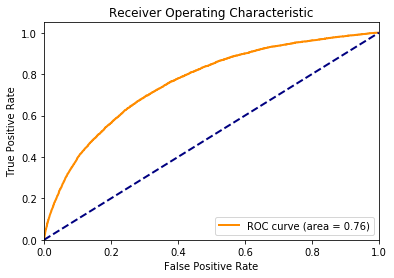

In [10]:
# plot ROC curve
y_score = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 5. KNN

In [11]:
import time
start = time.clock()

Kfold, niter, verbose, random_state = [5, 5, 0, 123] 
param_space = {'n_neighbors': range(1,20)}

clf = KNeighborsClassifier()
cv_clf = RandomizedSearchCV(clf, param_space, cv=Kfold, n_iter=niter, verbose=verbose, n_jobs = -1)
cv_clf.fit(X_train_new_x, y_train_new)
best_k = cv_clf.best_params_['n_neighbors']
print("Best number of neighbors is: ", best_k)

print('completed in {} s'.format(time.clock() - start))

# write out results
rlt_dict = {}
rlt_dict['best_k'] = [best_k]

rlt_df = pd.DataFrame.from_dict(rlt_dict)
rlt_df.to_csv('knn_cv_rlt.csv')

Best number of neighbors is:  19
completed in 3.0399999999999636 s


In [12]:
preds = cv_clf.predict(X_test)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, preds, labels=None, sample_weight=None)
report = classification_report(y_test, preds)
probs = cv_clf.predict_proba(X_test)
auc = roc_auc_score(y_test, probs[:,1])
accuracy = float(np.sum(preds==y_test))/y_test.shape[0] 

print("Confusion Matrix is: \n", confusion_matrix)
print("Classification Report: \n", report)
print("accuracy: %f" % (accuracy))
print("AUC: ", auc)

Confusion Matrix is: 
 [[32527 24006]
 [ 2203  2765]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.58      0.71     56533
           1       0.10      0.56      0.17      4968

   micro avg       0.57      0.57      0.57     61501
   macro avg       0.52      0.57      0.44     61501
weighted avg       0.87      0.57      0.67     61501

accuracy: 0.573844
AUC:  0.5861651640885336


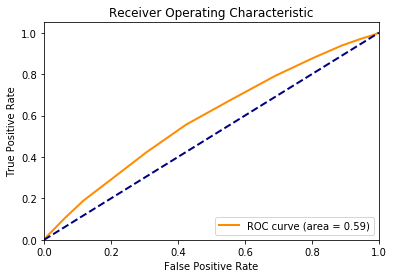

In [13]:
# plot ROC curve
y_score = probs[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 6. SVM

In [4]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
import warnings
warnings.filterwarnings("ignore")

In [5]:
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train_new_x)
X_train_new = scaling.transform(X_train_new_x)
X_test_new = scaling.transform(X_test)
X_train_new = pd.DataFrame(X_train_new)
X_train_new.columns = X_train_new_x.columns

In [6]:
import time
start = time.clock()

#param_space = {'C': [10], 'kernel': ['rbf'], 'gamma': [0.001]}
Kfold, niter, verbose, random_state = [2, 3, 0, 123] 
param_space = {'C': range(1,101), 'kernel': ['linear','rbf','poly'], 'gamma': [0.001, 0.0001]}

clf = svm.SVC(random_state=random_state)
cv_clf = RandomizedSearchCV(clf, param_space, cv=Kfold, n_iter=niter, verbose=verbose, n_jobs = -1) 
cv_clf.fit(X_train_new.values, y_train_new.values)

best_c = cv_clf.best_params_['C']
best_kernel = cv_clf.best_params_['kernel']  
best_gamma = cv_clf.best_params_['gamma']
print("Best C, kernel and gamma are: ", best_c, best_kernel, best_gamma) 

print('completed in {} s'.format(time.clock() - start))

# write out results
rlt_dict = {}
rlt_dict['best_c'] = [best_c]# bracket is necessary as each key will be treated as col name
rlt_dict['best_kernel'] = [best_kernel]
rlt_dict['best_gamma'] = [best_gamma]

rlt_df = pd.DataFrame.from_dict(rlt_dict)
rlt_df.to_csv('kernelsvm_cv_rlt.csv')

Best C, kernel and gamma are:  71 rbf 0.0001
completed in 704.76 s


In [7]:
import time
start = time.clock()

preds = cv_clf.predict(X_test_new)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, preds, labels=None, sample_weight=None)
report = classification_report(y_test, preds)

# cv_clf does not have predict_proba attribute in SVM
# fit the model with the best parameters and use the decision_function attribute of the model to calculate auc
clf = svm.SVC(C = best_c, kernel = best_kernel, gamma = best_gamma, random_state = random_state)
clf.fit(X_train_new.values, y_train_new.values)

probs = clf.decision_function(X_test_new)
auc = roc_auc_score(y_test, probs)
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]

print("Confusion Matrix is: \n", confusion_matrix)
print("Classification Report: \n", report)
print("accuracy: %f" % (accuracy))
print("AUC: ", auc)

print('completed in {} s'.format(time.clock() - start))

Confusion Matrix is: 
 [[39563 16970]
 [ 1566  3402]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.70      0.81     56533
           1       0.17      0.68      0.27      4968

   micro avg       0.70      0.70      0.70     61501
   macro avg       0.56      0.69      0.54     61501
weighted avg       0.90      0.70      0.77     61501

accuracy: 0.698607
AUC:  0.757809651342113
completed in 2296.17 s


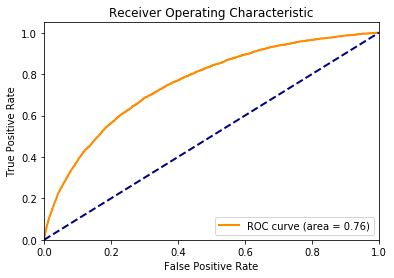

In [8]:
# plot ROC curve
y_score = probs
fpr, tpr, thresholds = roc_curve(y_test, y_score)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Conclusion

Table below summarizes the performance metrics for each of the models we built. Using AUC as criteria, the best model is XGboost. 

In [9]:
model_summary = {'RandomForest': {'Accuracy': 0.7053, 'AUC': 0.7549, 'F1-0': 0.82, 'F1-1': 0.27}, 
                 'XGboost': {'Accuracy': 0.7125, 'AUC': 0.7748, 'F1-0': 0.82, 'F1-1': 0.28},
                 'LightGBM': {'Accuracy': 0.7084, 'AUC': 0.7740, 'F1-0': 0.82, 'F1-1': 0.28},
                 'Logistic': {'Accuracy': 0.7006, 'AUC': 0.7618, 'F1-0': 0.81, 'F1-1': 0.27},
                 'KNN': {'Accuracy': 0.5738, 'AUC': 0.5862, 'F1-0': 0.71, 'F1-1': 0.17},
                 'SVM': {'Accuracy': 0.6986, 'AUC': 0.7578, 'F1-0': 0.81, 'F1-1': 0.27}
                }
model_summary = pd.DataFrame(model_summary)
display(model_summary)

,RandomForest,XGboost,LightGBM,Logistic,KNN,SVM
AUC,0.7549,0.7748,0.7740,0.7618,0.5862,0.7578
Accuracy,0.7053,0.7125,0.7084,0.7006,0.5738,0.6986
F1-0,0.8200,0.8200,0.8200,0.8100,0.7100,0.8100
F1-1,0.2700,0.2800,0.2800,0.2700,0.1700,0.2700


Plot the top 10 features selected by XGboost.

In [20]:
best = pd.read_csv('xgboost_cv_rlt.csv')
best_n = best.best_n.values[0]
best_lr = best.best_lr.values[0]
best_d = best.best_d.values[0]
best_gamma = best.best_gamma.values[0]

clf = XGBClassifier(n_estimators = best_n, learning_rate = best_lr, max_depth = best_d, 
                            gamma = best_gamma, objective='binary:logistic', booster='gbtree', tree_method='auto', 
                            subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, 
                            reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, 
                            random_state = 123)
clf.fit(X_train_new_x, y_train_new)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.01,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, tree_method='auto', verbosity=1)

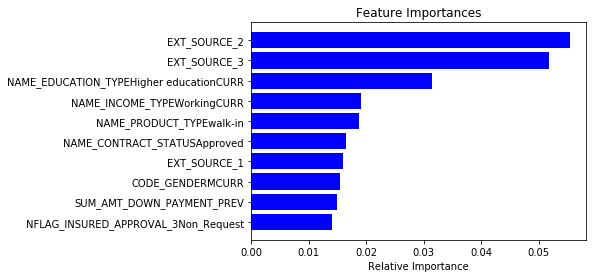

In [21]:
M = 10
importances = clf.feature_importances_
indices = np.argsort(importances)
features = X_train_new_x.columns

plt.title('Feature Importances')
plt.barh(range(M), importances[indices][-M:], color='b', align='center')
plt.yticks(range(M), [features[i] for i in indices[-M:]])
plt.xlabel('Relative Importance')
plt.show()